In [81]:
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)
import numpy as np
from sklearn.feature_extraction.image import extract_patches_2d
from numpy.lib import stride_tricks
import cv2
from matplotlib.colors import hsv_to_rgb
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(precision=3)

Populating the interactive namespace from numpy and matplotlib


In [82]:
class PatchMatch(object):
    def __init__(self, a, b, patch_size):
        assert a.shape == b.shape, "Dimensions were unequal for patch-matching input"
        self.A = a
        self.B = b
        self.patch_size = patch_size
        self.nnf = np.zeros((2, self.A.shape[0], self.A.shape[1])).astype(np.int)
        self.nnd = np.zeros((self.A.shape[0], self.A.shape[1]))
        self.initialise_nnf()
    
    def initialise_nnf(self):
        self.nnf[0] = np.random.randint(self.B.shape[0], size=(self.A.shape[0], self.A.shape[1]))
        self.nnf[1] = np.random.randint(self.B.shape[1], size=(self.A.shape[0], self.A.shape[1]))
        self.nnf = self.nnf.transpose((1, 2 ,0))
        for i in range(self.A.shape[0]):
            for j in range(self.A.shape[1]):
                pos = self.nnf[i,j]
                self.nnd[i,j] = self.cal_dist(i, j, pos[0], pos[1])
    
    def cal_dist(self, ai ,aj, bi, bj):
        dx0 = dy0 = self.patch_size//2
        dx1 = dy1 = self.patch_size//2 + 1
        dx0 = min(ai, bi, dx0)
        dx1 = min(self.A.shape[0]-ai, self.B.shape[0]-bi, dx1)
        dy0 = min(aj, bj, dy0)
        dy1 = min(self.A.shape[1]-aj, self.B.shape[1]-bj, dy1)
        return np.sum((self.A[ai-dx0:ai+dx1, aj-dy0:aj+dy1]-self.B[bi-dx0:bi+dx1, bj-dy0:bj+dy1])**2) / (dx1+dx0) / (dy1+dy0)
        
        
    def calculate_dist(self, ai ,aj, bi, bj):
        dx0 = dy0 = self.patch_size//2
        dx1 = dy1 = self.patch_size//2 + 1
        dx0 = min(ai, bi, dx0)
        dx1 = min(self.a.shape[0]-ai, self.b.shape[0]-bi, dx1)
        dy0 = min(aj, bj, dy0)
        dy1 = min(self.a.shape[1]-aj, self.b.shape[1]-bj, dy1)
        return np.sum((self.a[ai-dx0:ai+dx1, aj-dy0:aj+dy1]-self.b[bi-dx0:bi+dx1, bj-dy0:bj+dy1])**2) / (dx1+dx0) / (dy1+dy0)
    
    def reconstruct(self):
        ans = np.zeros_like(self.A)
        for i in range(self.A.shape[0]):
            for j in range(self.A.shape[1]):
                pos = self.nnf[i,j]
                ans[i,j] = self.B[pos[0], pos[1]]
        return ans
      
    def propagate(self):
        compare_value = -1 
        for i in range(self.A.shape[0]):
            for j in range(self.A.shape[1]):
                x,y = self.nnf[i,j]
                bestx, besty, bestd = x, y, self.nnd[i,j]
                
                compare_value *=-1
                                
                if (i + compare_value >= 0 and compare_value == -1) or (i + compare_value < self.A.shape[0] and compare_value == 1) :
                    rx, ry = self.nnf[i+compare_value, j][0] , self.nnf[i+compare_value, j][1]
                    if rx < self.B.shape[0]:
                        val = self.cal_dist(i, j, rx, ry)
                        if val < bestd:
                            bestx, besty, bestd = rx, ry, val

                if (j+compare_value >= 0 and compare_value == -1)or (j + compare_value < self.A.shape[1] and compare_value == 1) :
                    rx, ry = self.nnf[i, j+compare_value][0], self.nnf[i, j+compare_value][1] 
                    if ry < self.B.shape[1]:
                        val = self.cal_dist(i, j, rx, ry)
                        if val < bestd:
                            bestx, besty, bestd = rx, ry, val
                            
                rand_d = min(self.B.shape[0]//2, self.B.shape[1]//2)
                while rand_d > 0:
                    try:
                        xmin = max(bestx - rand_d, 0)
                        xmax = min(bestx + rand_d, self.B.shape[0])
                        ymin = max(besty - rand_d, 0)
                        ymax = min(besty + rand_d, self.B.shape[1])
                    #print(xmin, xmax)
                        rx = np.random.randint(xmin, xmax)
                        ry = np.random.randint(ymin, ymax)
                        val = self.cal_dist(i, j, rx, ry)
                        if val < bestd:
                            bestx, besty, bestd = rx, ry, val
                    except:
                        print(rand_d)
                        print(xmin, xmax)
                        print(ymin, ymax)
                        print(bestx, besty)
                        print(self.B.shape)
                    rand_d = rand_d // 2

                self.nnf[i, j] = [bestx, besty]
                self.nnd[i, j] = bestd
                
        print("Done")
                
                
        
        

In [96]:
# test_a = np.random.randint(low=0,high=10,size=(7,100, 100))
# test_b = np.random.randint(low=0,high=10,size=(7,100, 100))

x = cv2.imread("./aa.jpg")
y = cv2.imread("./bb.jpg")
z = cv2.imread("./aa3.jpg")


x = cv2.resize(x,(200,200))
y = cv2.resize(y,(200,200))


In [ ]:
def do():
    pm = PatchMatch(x,y, 5)
    pm.propagate()
    pm.propagate()
    pm.propagate()
    pm.propagate()
%timeit -N 1 do()

In [98]:
pm.propagate()
pm.propagate()
pm.propagate()
pm.propagate()

Done
Done
Done
Done


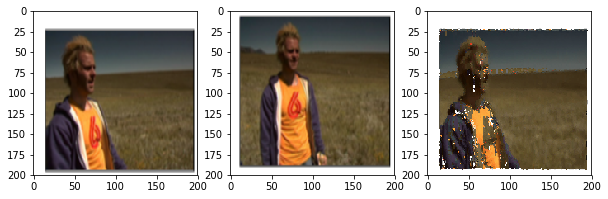

In [99]:
plt.figure(1)
plt.subplot(131)
plt.imshow(x[:,:,::-1])

plt.subplot(132)
plt.imshow(y[:,:,::-1])

plt.subplot(133)
plt.imshow(pm.reconstruct()[:,:,::-1])

plt.show()

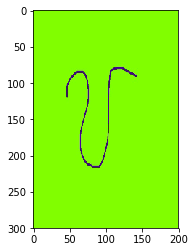

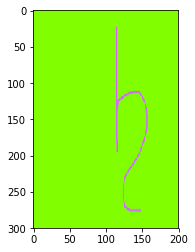

In [304]:
plt.imshow(x)
plt.show()
plt.imshow(y)
plt.show()

In [ ]:
pm.propagate()
pm.back_propagate()
pm.propagate()
pm.back_propagate()
pm.propagate()
pm.back_propagate()
pm.reconstruct_img(patch_size=3)
plt.show()

In [ ]:
pm.reconstruct_img(patch_size=3)
plt.show()
pm.reconstruct_img(patch_size=1)
plt.show()
pm.reconstruct_img(patch_size=5)
plt.show()



In [ ]:
reconstruct()

In [ ]:
pm.get_patch_for_coords(x,0,0)

(3, 275, 183)


In [ ]:
x[:,0:3,0:3]

In [ ]:
pm.a[:,7+2,8+2]

In [ ]:
pm.nnf[:,0,0] = [2,2]

In [ ]:
pm.nnf[:,0,0]

In [ ]:
x = cv2.imread("/Users/harshvardhangupta/Deep-Image-Analogy/notebooks/Unknown.jpeg").transpose(2,1,0)
# x = x[:,:4,:4]
# x

In [ ]:
np.pad(x,pad_width=((0,0),(1,1),(1,1)),mode='constant')

In [ ]:
pm.get_patch_for_coords(pm.a_padded,5,5)

In [ ]:
x[:,y+self.offset_from_edge: y + self.patch_size , x+self.offset_from_edge : x+self.patch_size]

In [ ]:
x[:,36+1 : 36 + 4 , 36+1 : 36+4]

In [ ]:
ax 36  ay 0  bx 182  by 8

In [ ]:
x[:,8+1:8+3,182+1:182+3]

In [ ]:
x.shape

In [ ]:
padded_x = np.pad(x,pad_width=((0,0),(1,1),(1,1)),mode='constant')

In [ ]:
x.shape

In [ ]:
padded_x

In [ ]:
padded_x[:,8:8+4,182:182+3]

In [120]:
from matplotlib.colors import hsv_to_rgb
import matplotlib.pyplot as plt
import numpy as np
np.seterr(all='raise')

def unit_vector(vector):
    try:
        result = vector / np.linalg.norm(vector)
        return result
    except:
#         print(vector)
#         print(np.linalg.norm(vector))
        return [0.0,0.0]
    
test_list = []
def angle_between(v1, v2):
    v1, v2 = np.array(v1,dtype=np.float32), np.array(v2,dtype=np.float32)
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    assert v1_u is not None , "V1 none"
    assert v2_u is not None , "V2 none"
    test_list.append(np.rad2deg(np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))))
#     print(v1_u)
#     print(v2_u)
    
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

def norm_dist(arr):
    return (arr)/(arr.max())

def visualize_nnf(nnf, nnd):
    img = np.zeros((nnf.shape[1], nnf.shape[2], 3),dtype=np.float32)
    for i in range(1, nnf.shape[1]):
        for j in range(1, nnf.shape[2]):
            angle = angle_between_alt([j, i], [nnf[0, i, j], nnf[1, i, j]])

            img[i, j, :] = np.array([angle, nnd[i,j], 350])
    img = hsv_to_rgb(norm_dist(img))
#     print(np.unique(img))

    plt.imshow(img)

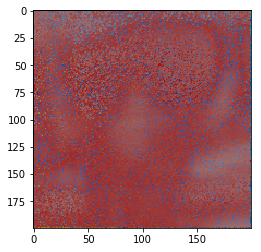

In [121]:
visualize_nnf(pm.nnf,pm.nnd)

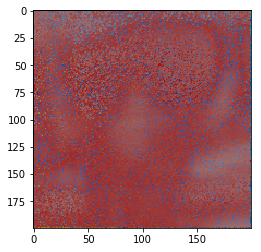

In [122]:
visualize_nnf(pm.nnf,pm.nnd)

In [226]:

# def unit_vector(vector):
#     """ Returns the unit vector of the vector.  """
#     return vector / np.linalg.norm(vector)

# def angle_between(v1, v2):

#     v1_u = unit_vector(v1)
#     v2_u = unit_vector(v2)
#     return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))


# def visualize_nnf(nnf, nnd):
#     img = np.zeros((nnf.shape[1], nnf.shape[2], 3),dtype=np.float32)
#     for i in range(1, nnf.shape[1]):
#         for j in range(1, nnf.shape[2]):
#             angle = angle_between_al([j, i], [nnf[0, i, j], nnf[1, i, j]])
#             img[i, j, :] = np.array([angle, nnd[i,j], 1.0])
#     img = hsv_to_rgb(norm_dist(img*255))
#     plt.imshow(img)

In [225]:
# tx = np.array([1,1],dtype=np.int32)
# ty = np.array([0,0],dtype=np.int32)


# angle_between((0, 0), (1,1))

FloatingPointError: invalid value encountered in true_divide

In [ ]:
plt.imshow(pm.nnd.T/255)

In [ ]:
pm.nnd.shape

In [ ]:
pm.nnf.shape

In [ ]:
def reconstruct():
    img = np.zeros(shape=(3,200,200),dtype=np.uint8)

    for i in range(200):
        for j in range(200):
            t_x = pm.nnf[0][i][j] 
            t_y = pm.nnf[1][i][j]
    #         print(t_x)
    #         print(t_y)
    #         print()
            img[0][i][j] = y[0][t_y][t_x]
            img[1][i][j] = y[1][t_y][t_x]
            img[2][i][j] = y[2][t_y][t_x]
    #         print(y[0][t_y][t_x])
    #         print(y[1][t_y][t_x])
    #         print(y[2][t_y][t_x])
    #         print()
    #         print(np.unique(img))

    #         print(img[0,j,i])
    #         print(img[1,j,i])
    #         print(img[2,j,i])
    #         print()
    plt.imshow(img.transpose(2,1,0)[:,:,::-1]*255)
    print(np.unique(img))

In [ ]:
reconstruct()

In [ ]:
np.unique(img)

In [ ]:
y[:,20:50,20:50]

In [ ]:
img.shape

In [ ]:
plt.imshow(img.transpose(2,1,0)[:,:,::-1])

In [ ]:
plt.imshow(pm.a_padded.transpose(2,1,0))

In [ ]:
pm.a.shape

In [ ]:
plt.imshow(a.transpose(1,2,0))

In [ ]:
plt.imshow(b.transpose(1,2,0))

In [ ]:
pm.nnd.shape

In [ ]:
plt.imshow(pm.nnd)

In [ ]:
padded_nnf = pm._pad_matrix(pm.nnf)

In [ ]:
nnf_patch = pm.get_patch_for_coords(padded_nnf, 0, 53,patch_size=3)
nnf_patch.shape


In [ ]:
for i in range(200):
    for j in range(200):
        print(" j{} i{} NNFx--{} NNFy--{} ".format(j,i,pm.nnf[0][i][j] , pm.nnf[1][i][j]))
        if j == pm.nnf[0][i][j] and i ==pm.nnf[0][i][j]:
            print("SAME")

In [ ]:
np.unique(pm.nnf)

In [ ]:
np.histogram(pm.nnf[0])

In [22]:
0/0

ZeroDivisionError: division by zero

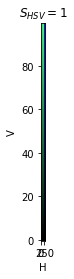

In [89]:
V, H = np.mgrid[0:1:100j, 0:1:300j]
S = np.ones_like(V)
HSV = np.dstack((H,S,V))
RGB = hsv_to_rgb(HSV)
plt.imshow(RGB, origin="lower", extent=[0, 360, 0, 1], aspect=150)
plt.xlabel("H")
plt.ylabel("V")
plt.title("$S_{HSV}=1$")
plt.show()

In [182]:
np.unique(np.array(test_list))

array([  0.000e+00,   1.978e-02,   2.798e-02,   3.426e-02,   3.956e-02,
         4.423e-02,   4.846e-02,   5.234e-02,   5.595e-02,   5.935e-02,
         6.256e-02,   6.561e-02,   6.853e-02,   7.133e-02,   7.402e-02,
         7.662e-02,   7.913e-02,   8.156e-02,   8.393e-02,   8.623e-02,
         8.847e-02,   9.065e-02,   9.279e-02,   9.487e-02,   9.691e-02,
         9.891e-02,   1.009e-01,   1.028e-01,   1.047e-01,   1.065e-01,
         1.084e-01,   1.101e-01,   1.119e-01,   1.136e-01,   1.153e-01,
         1.170e-01,   1.187e-01,   1.219e-01,   1.235e-01,   1.251e-01,
         1.282e-01,   1.297e-01,   1.312e-01,   1.327e-01,   1.342e-01,
         1.356e-01,   1.371e-01,   1.385e-01,   1.399e-01,   1.413e-01,
         1.427e-01,   1.440e-01,   1.454e-01,   1.467e-01,   1.480e-01,
         1.507e-01,   1.520e-01,   1.532e-01,   1.545e-01,   1.558e-01,
         1.570e-01,   1.583e-01,   1.607e-01,   1.619e-01,   1.631e-01,
         1.643e-01,   1.655e-01,   1.667e-01,   1.679e-01,   1.7

In [181]:
np.set_printoptions(threshold=np.nan)

In [202]:
# def angle_between(v1, v2):

#     v1_u = unit_vector(v1)
#     v2_u = unit_vector(v2)
#     return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))
angle_between([0, 1], [5, 5])

0.78539819

In [5]:
import numpy as np

def angle_between_alt(p1, p2):
    ang1 = np.arctan2(*p1[::-1])
    ang2 = np.arctan2(*p2[::-1])
    return np.rad2deg((ang1 - ang2) % (2 * np.pi))

In [223]:
angle_between_alt([0,0],[1,1])

315.0

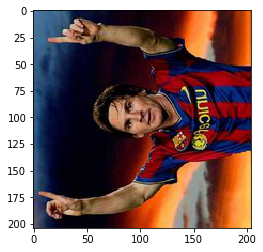

In [9]:
plt.imshow(pm.a_padded.transpose(2,1,0))

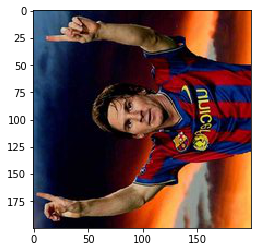

In [12]:
plt.imshow(pm.a.transpose(2,1,0))

In [13]:
pm.get_patch_for_coords(b,0,0)

array([[[197, 197, 196, 196, 196],
        [196, 196, 196, 195, 196],
        [196, 196, 196, 196, 196],
        [197, 197, 197, 197, 198],
        [200, 200, 200, 200, 200]],

       [[192, 192, 191, 191, 191],
        [191, 191, 191, 190, 191],
        [191, 191, 191, 191, 191],
        [192, 192, 192, 192, 193],
        [195, 195, 195, 195, 195]],

       [[172, 172, 171, 171, 171],
        [171, 171, 171, 170, 171],
        [171, 171, 171, 171, 171],
        [172, 172, 172, 172, 173],
        [176, 176, 176, 176, 176]]], dtype=uint8)

In [14]:
pm.get_patch_for_coords(pm.b_padded,0,0)

array([[[196, 196, 196, 196, 196],
        [196, 196, 196, 196, 196],
        [196, 197, 197, 197, 196],
        [196, 196, 196, 196, 196],
        [196, 196, 196, 196, 196]],

       [[191, 191, 191, 191, 191],
        [191, 191, 191, 191, 191],
        [191, 192, 192, 192, 191],
        [191, 191, 191, 191, 191],
        [191, 191, 191, 191, 191]],

       [[171, 171, 171, 171, 171],
        [171, 171, 171, 171, 171],
        [171, 172, 172, 172, 171],
        [171, 171, 171, 171, 171],
        [171, 171, 171, 171, 171]]], dtype=uint8)